In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from xgboost import XGBRegressor
import random
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# Data import

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


# EDA

In [5]:
test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
id        200000 non-null int64
cat0      200000 non-null object
cat1      200000 non-null object
cat2      200000 non-null object
cat3      200000 non-null object
cat4      200000 non-null object
cat5      200000 non-null object
cat6      200000 non-null object
cat7      200000 non-null object
cat8      200000 non-null object
cat9      200000 non-null object
cont0     200000 non-null float64
cont1     200000 non-null float64
cont2     200000 non-null float64
cont3     200000 non-null float64
cont4     200000 non-null float64
cont5     200000 non-null float64
cont6     200000 non-null float64
cont7     200000 non-null float64
cont8     200000 non-null float64
cont9     200000 non-null float64
cont10    200000 non-null float64
cont11    200000 non-null float64
cont12    200000 non-null float64
cont13    200000 non-null float64
dtypes: float64(14), int64(1), object(10)
memory us

In [6]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [7]:
train.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250018.576947,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,144450.150010,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,1.000000,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,124772.500000,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,250002.500000,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,375226.500000,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,499999.000000,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [8]:
# Checking if there are missing values in the datasets
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

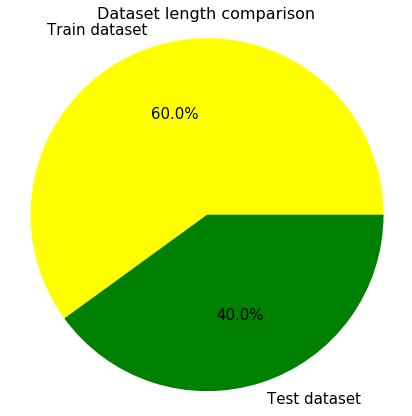

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
pie = ax.pie([len(train), len(test)],
             labels=["Train dataset", "Test dataset"],
             colors=["yellow", "green"],
             textprops={"fontsize": 15},
             autopct='%1.1f%%')
ax.axis("equal")
ax.set_title("Dataset length comparison", fontsize=16)
fig.set_facecolor('white')
plt.show();

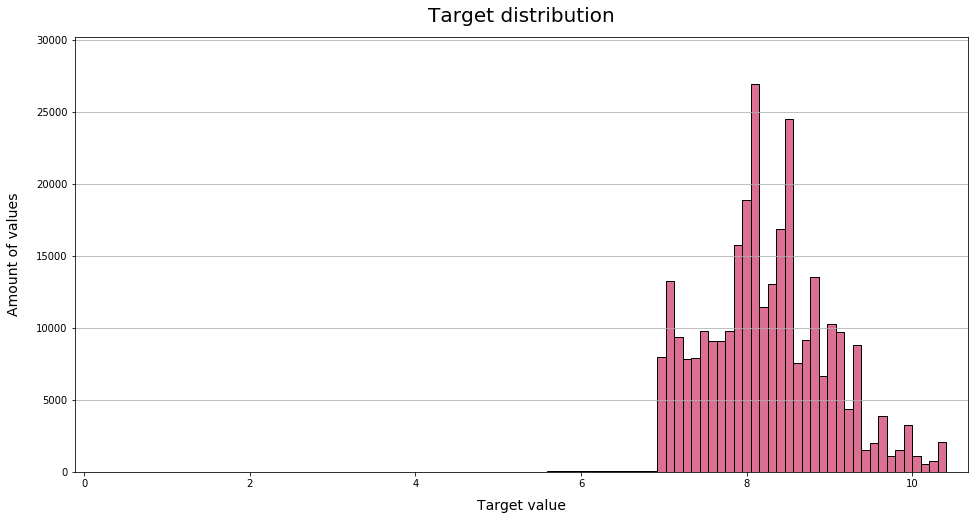

In [10]:
# Checking target distribution

fig, ax = plt.subplots(figsize=(16, 8))

bars = ax.hist(train["target"],
               bins=100,
               color="palevioletred",
               edgecolor="black")
ax.set_title("Target distribution", fontsize=20, pad=15)
ax.set_ylabel("Amount of values", fontsize=14, labelpad=15)
ax.set_xlabel("Target value", fontsize=14, labelpad=10)
ax.margins(0.025, 0.12)
ax.grid(axis="y")

plt.show();

In [11]:
# Lists of categorical and numerical feature columns
cat_features = ["cat" + str(i) for i in range(10)]
num_features = ["cont" + str(i) for i in range(14)]

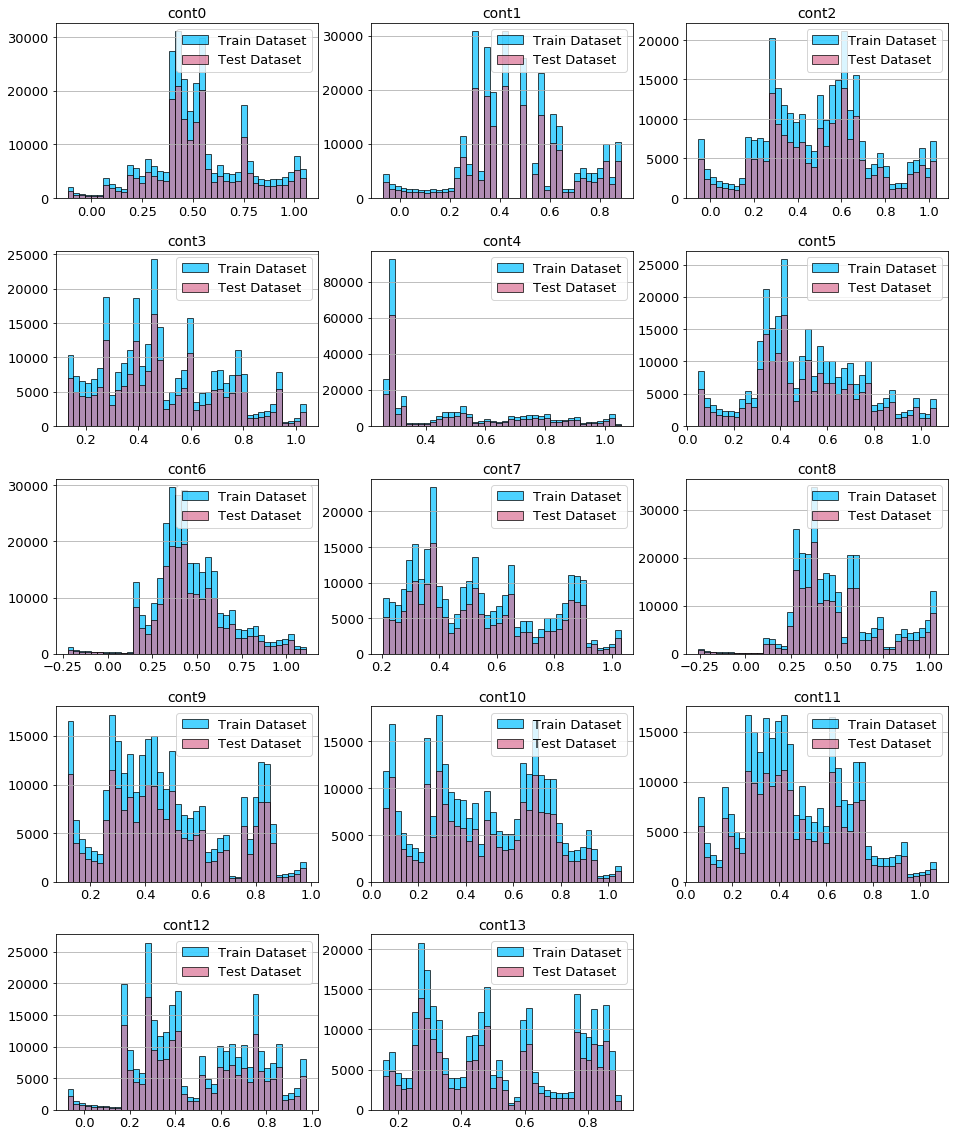

In [12]:
# Combined dataframe containing numerical features only
df = pd.concat([train[num_features], test[num_features]], axis=0)
columns = df.columns.values

# Calculating required amount of rows to display all feature plots
cols = 3
rows = len(columns) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(16,20), sharex=False)

# Adding some distance between plots
plt.subplots_adjust(hspace = 0.3)

# Plots counter
i=0
for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(columns): # If there is no more data columns to make plots from
            axs[r, c].set_visible(False) # Hiding axes so there will be clean background
        else:
            # Train data histogram
            hist1 = axs[r, c].hist(train[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="deepskyblue",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Train Dataset")
            # Test data histogram
            hist2 = axs[r, c].hist(test[columns[i]].values,
                                   range=(df[columns[i]].min(),
                                          df[columns[i]].max()),
                                   bins=40,
                                   color="palevioletred",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Test Dataset")
            axs[r, c].set_title(columns[i], fontsize=14, pad=5)
            axs[r, c].tick_params(axis="y", labelsize=13)
            axs[r, c].tick_params(axis="x", labelsize=13)
            axs[r, c].grid(axis="y")
            axs[r, c].legend(fontsize=13)
                                  
        i+=1
# plt.suptitle("Numerical feature values distribution in both datasets", y=0.99)
plt.show();

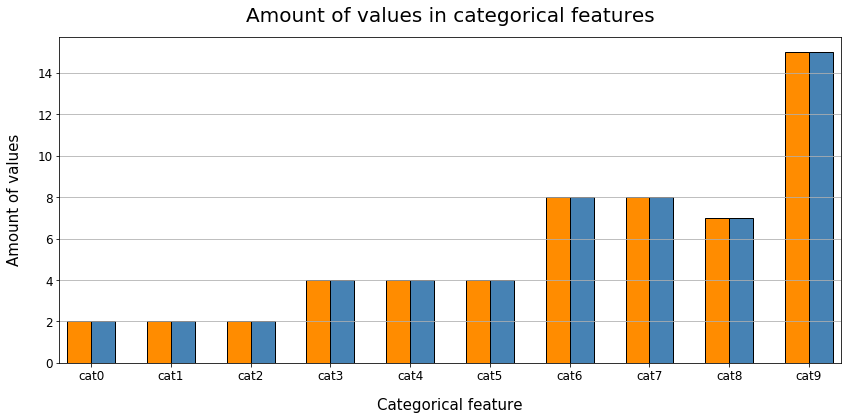

In [13]:
#Check if the datasets have different amount of categories in categorical features.
bars_pos = np.arange(len(cat_features))

width=0.3
fig, ax = plt.subplots(figsize=(14, 6))
# Making two bar objects. One is on the left from bar position and the other one is on the right
bars1 = ax.bar(bars_pos-width/2,
               train[cat_features].nunique().values,
               width=width,
               color="darkorange", edgecolor="black")
bars2 = ax.bar(bars_pos+width/2,
               test[cat_features].nunique().values,
               width=width,
               color="steelblue", edgecolor="black")
ax.set_title("Amount of values in categorical features", fontsize=20, pad=15)
ax.set_xlabel("Categorical feature", fontsize=15, labelpad=15)
ax.set_ylabel("Amount of values", fontsize=15, labelpad=15)
ax.set_xticks(bars_pos)
ax.set_xticklabels(cat_features, fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(axis="y")
plt.margins(0.01, 0.05)

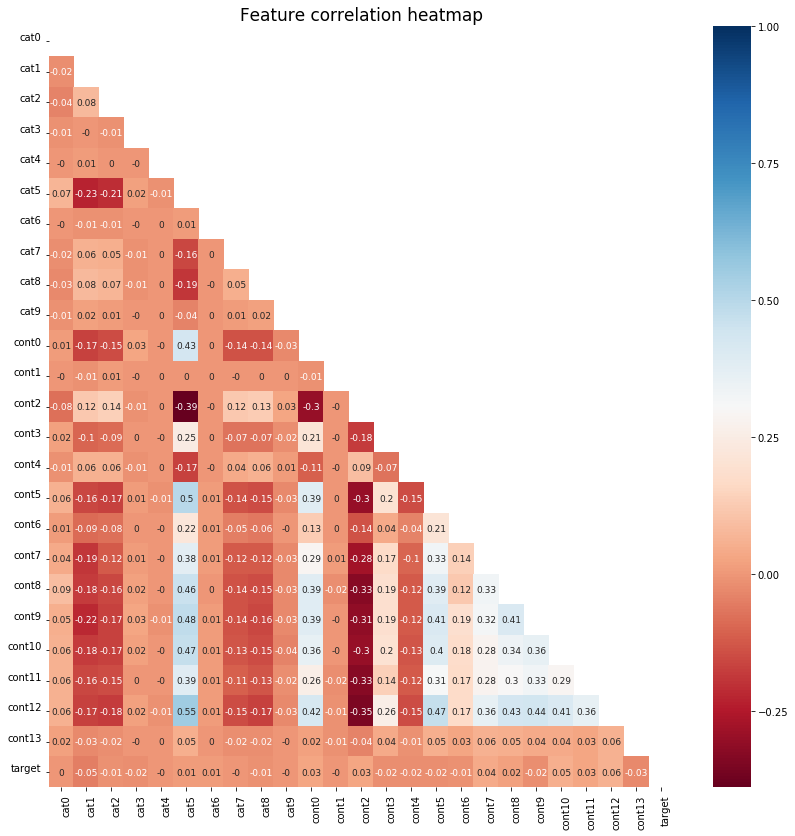

In [14]:
#Correlation map
df = train.drop("id", axis=1)

# Encoding categorical features with OrdinalEncoder
for col in cat_features:
    encoder = OrdinalEncoder()
    df[col] = encoder.fit_transform(np.array(df[col]).reshape(-1, 1))

# Calculatin correlation values
df = df.corr().round(2)

# Mask to hide upper-right part of plot as it is a duplicate
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True

# Making a plot
plt.figure(figsize=(14,14))
ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "normal", "fontsize":9})
ax.set_title("Feature correlation heatmap", fontsize=17)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", weight="normal")
plt.setp(ax.get_yticklabels(), weight="normal",
         rotation_mode="anchor", rotation=0, ha="right")
plt.show();